In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow.keras
import torch
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

# -- Импорт для построения модели: --
# импорт слоев
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Flatten
# импорт модели
from tensorflow.keras.models import Sequential
# импорт оптимайзера
from tensorflow.keras.optimizers import Adam

c:\Users\igl\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df_train = pd.read_csv('c://data/df/train6.csv')
df_test = pd.read_csv('c://data/df/test.csv')

In [3]:
# Обзор датасета

df_test.shape

(28000, 784)

In [4]:
df_test.shape

(28000, 784)

In [5]:
# Пропусков нет
df_train.isnull().sum().sum()

0

In [6]:
# Пропусков нет
df_test.isnull().sum().sum()

0

In [7]:
# label - целевой признак, остальное исходные данные

df_train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
# здесь целевого признака нет, только исходные данные
df_test.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
# Получается одна строка это изображение 28 на 28 пикселей
784**(1/2)

28.0

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [11]:
# забираем label в целевой признак
y = df_train['label']
y = y.to_numpy()
df_train.drop(columns = ['label'], axis = 1, inplace=True)
X = df_train.to_numpy(dtype=np.float32)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=17, shuffle=True, stratify=y)

# тестовый загрузим в массив val
val = df_test.to_numpy(dtype=np.float32)

In [12]:
# Переведем в тензор
X_train = torch.from_numpy(X_train).to(device)
X_test = torch.from_numpy(X_test).to(device)
y_train = torch.from_numpy(y_train).to(device)
y_test = torch.from_numpy(y_test).to(device)
val_tens = torch.from_numpy(val).to(device)

In [13]:
import torchvision.transforms as transforms
import torchvision.datasets as dsets
from torch import nn, optim
import tqdm as tqdm

In [14]:
# определим размеры слоев
input_size = 784
hidden_sizes = 200
output_size = 10

In [15]:
# Определим модель нн
model = nn.Sequential(nn.Linear(input_size, hidden_sizes),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes, output_size),
                      nn.Sigmoid())

print(model)

Sequential(
  (0): Linear(in_features=784, out_features=200, bias=True)
  (1): ReLU()
  (2): Linear(in_features=200, out_features=10, bias=True)
  (3): Sigmoid()
)


In [16]:

criterion = torch.nn.CrossEntropyLoss()


In [17]:
# Зададим количество эпох и шаг
learning_rate = 0.01
epochs = 1000

# Объявим оптимизатор:
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)  

# Переменные для расчета метрики
correct, total = 0, 0

In [18]:
# Обучим
for cur_epoch in tqdm.trange(epochs):
    y_pred = model(X_train)
    loss = criterion(y_pred, y_train)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    y_value = torch.argmax(y_pred, dim=1)
    correct += (y_value == y_train).sum().item()
    total += y_train.shape[0]
    if (cur_epoch + 1) % (epochs // 10) == 0:
        print(f'\tEpoch: {cur_epoch + 1}/{epochs}, Loss: {loss.item():.4f}')


 10%|█         | 101/1000 [00:16<02:27,  6.09it/s]

	Epoch: 100/1000, Loss: 1.6092


 20%|██        | 201/1000 [00:33<02:11,  6.08it/s]

	Epoch: 200/1000, Loss: 1.5608


 30%|███       | 301/1000 [00:50<01:59,  5.87it/s]

	Epoch: 300/1000, Loss: 1.5447


 40%|████      | 401/1000 [01:07<01:45,  5.69it/s]

	Epoch: 400/1000, Loss: 1.5354


 50%|█████     | 501/1000 [01:26<01:26,  5.80it/s]

	Epoch: 500/1000, Loss: 1.5286


 60%|██████    | 601/1000 [01:44<01:21,  4.88it/s]

	Epoch: 600/1000, Loss: 1.5236


 70%|███████   | 701/1000 [02:03<00:55,  5.41it/s]

	Epoch: 700/1000, Loss: 1.5197


 80%|████████  | 801/1000 [02:22<00:38,  5.14it/s]

	Epoch: 800/1000, Loss: 1.5165


 90%|█████████ | 901/1000 [02:39<00:15,  6.23it/s]

	Epoch: 900/1000, Loss: 1.5140


100%|██████████| 1000/1000 [02:55<00:00,  5.70it/s]

	Epoch: 1000/1000, Loss: 1.5119


In [19]:
print(f'Train Accuracy: {correct / total:.4f}')

Train Accuracy: 0.8610


In [20]:
# Проверим на тестовой части
model.eval()
correct, total = 0, 0
y_pred = model(X_test)
#loss = criterion(y_pred, y_test)
y_value = torch.argmax(y_pred, dim=1)
correct += (y_value == y_test).sum().item()
total += y_test.shape[0]

print(f'Test Accuracy: {correct / total:.4f}')

Test Accuracy: 0.9258


Номер элемента:  26594
Предсказанное число:  tensor(0)


(-0.5, 27.5, 27.5, -0.5)

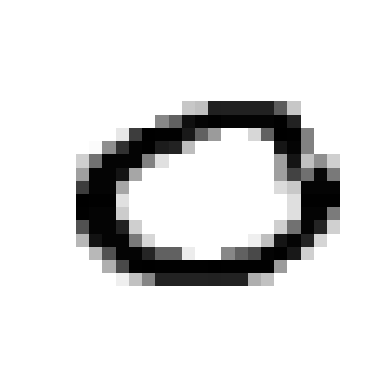

In [25]:
# Проверим на неразмеченном проверочном массиве. 
# Генерируем рандомно номер и выводим результат предсказания и оригинальную картинку
import random
model.eval()
number = random.randint(0, 27999)
print('Номер элемента: ', number)
y_pred = model(val_tens[number])
rez = torch.argmax(y_pred)
print('Предсказанное число: ', rez) #y_pred[rez])
temp = val.reshape(28000, 28, 28)
plt.imshow(temp[number], cmap='binary')
plt.axis('off')
